In [2]:
import torch
from time import time

a = torch.ones(1000)
b = torch.ones(1000)
start = time()
c = torch.zeros(1000)
for i in range(1000):
    c[i] = a[i] + b[i]
print(time() - start)

0.029004812240600586


## 矢量加法

In [3]:
start = time()
d = a + b
print(time() - start)

0.0


In [4]:
a = torch.ones(3)
b = 10
a + b

tensor([11., 11., 11.])

## 3.2 线性回归的从零开始实现

在了解了线性回归的背景知识之后，现在我们可以动⼿实现它了。尽管强⼤的深度学习框架可以减少⼤
量᯿复性⼯作，但若过于依赖它提供的便利，会导致我们很难深⼊理解深度学习是如何⼯作的。因此，
本节将介绍如何只利⽤ Tensor 和 autograd 来实现⼀个线性回归的训练。
⾸先，导⼊本节中实验所需的包或模块，其中的matplotlib包可⽤于作图，且设置成嵌⼊显示

In [6]:
import torch
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import random

### 3.2.1 ⽣成数据集

我们构造⼀个简单的⼈⼯训练数据集，它可以使我们能够直观⽐较学到的参数和真实的模型参数的区
别。设训练数据集样本数为1000，输⼊个数（特征数）为2。给定随机⽣成的批量样本特征
 ，我们使⽤线性回归模型真实权᯿ 和偏差 ，以及⼀个随机噪声
项 来⽣成标签

其中噪声项 服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中⽆意义的⼲扰。下⾯，让
我们⽣成数据集。

In [7]:
num_inputs = 2
num_examples = 1000
true_w = [2,-3.4]
true_b = 4.2
features = torch.from_numpy(np.random.normal(0,1,(num_examples,num_inputs)))
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += torch.from_numpy(np.random.normal(0,0.01,size = labels.size()))

注意， features 的每⼀⾏是⼀个⻓度为2的向量，⽽ labels 的每⼀⾏是⼀个⻓度为1的向量（标
量）。

In [9]:
print(features[0],labels[0])

tensor([-1.5470, -0.9766], dtype=torch.float64) tensor(4.4321, dtype=torch.float64)


通过⽣成第⼆个特征 features[:, 1] 和标签 labels 的散点图，可以更直观地观察两者间的线性关
系。

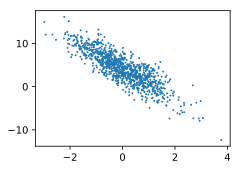

In [10]:
def use_svg_display():
    #用矢量图显示
    display.set_matplotlib_formats('svg')
    
def set_figsize(figsize = (3.5,2.5)):
    use_svg_display()
    #设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch⾥⾯添加上⾯两个函数后就可以这样导⼊
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import *

set_figsize()
plt.scatter(features[:,1].numpy(),labels.numpy(),1);

我们将上⾯的 plt 作 图 函 数 以 及 use_svg_display 函 数 和 set_figsize 函 数 定 义
在 d2lzh_pytorch 包 ⾥ 。 以 后 在 作 图 时 ， 我 们 将 直 接 调 ⽤ d2lzh_pytorch.plt 。 由 于 plt
在 d2lzh_pytorch 包 中 是 ⼀ 个 全 局 变 量 ， 我 们 在 作 图 前 只 需 要 调
⽤ d2lzh_pytorch.set_figsize() 即可打印⽮量图并设置图的尺⼨

### 3.2.2 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取⼩批量数据样本。这⾥我们定义⼀个函数：它每次
返回 batch_size （批量⼤⼩）个随机样本的特征和标签。

In [11]:
#本函数已保存在d2lzh包中方便调用
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        j = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        yield features.index_select(0,j),labels.index_select(0,j)

让我们读取第⼀个⼩批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量⼤⼩和输⼊个
数；标签形状为批量⼤⼩。

In [12]:
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,y)
    break

tensor([[ 1.8727,  1.1477],
        [ 1.5246, -0.7438],
        [ 0.2386, -0.0103],
        [-1.3361,  0.6021],
        [-0.5886,  1.8019],
        [-1.3700, -1.6063],
        [ 0.3843,  0.9060],
        [-0.3831,  0.0042],
        [-0.1128, -1.6415],
        [-0.8717, -0.0182]], dtype=torch.float64) tensor([ 4.0358,  9.7875,  4.7213, -0.5166, -3.1224,  6.9160,  1.8842,  3.4159,
         9.5480,  2.5191], dtype=torch.float64)


### 3.2.3 初始化模型参数

In [15]:
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),
                dtype = torch.float64)
b = torch.zeros(1,dtype = torch.float64)

之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让它们的
requires_grad=True 。

In [16]:
w.requires_grad_(requires_grad = True)
b.requires_grad_(requires_grad = True)

tensor([0.], dtype=torch.float64, requires_grad=True)

### 3.2.4 定义模型

下⾯是线性回归的⽮量计算表达式的实现。我们使⽤ mm 函数做矩阵乘法。

In [17]:
def linreg(X,w,b):
    return torch.mm(X,w) + b

### 3.2.5 定义损失函数

我们使⽤上⼀节描述的平⽅损失来定义线性回归的损失函数。在实现中，我们需要把真实值 y 变形成预
测值 y_hat 的形状。以下函数返回的结果也将和 y_hat 的形状相同。

In [18]:
def squared_loss(y_hat,y):
    return (y_hat - y.view(y_hat.size()))**2 /2

### 3.2.6 定义优化算法

以下的 sgd 函数实现了上⼀节中介绍的⼩批量随机梯度下降算法。它通过不断迭代模型参数来优化损失
函数。这⾥⾃动求梯度模块计算得来的梯度是⼀个批量样本的梯度和。我们将它除以批量⼤⼩来得到平
均值。

In [19]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data -= lr*param.grad/batch_size    

### 3.2.7 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的⼩批量数据样本（特征 X 和
标签 y ），通过调⽤反向函数 backward 计算⼩批量随机梯度，并调⽤优化算法 sgd 迭代模型参数。
由于我们之前设批量⼤⼩ batch_size 为10，每个⼩批量的损失 l 的形状为(10, 1)。回忆⼀下⾃动求
梯度⼀节。由于变量 l 并不是⼀个标量，所以我们可以调⽤ .sum() 将其求和得到⼀个标量，再运
⾏ l.backward() 得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清
零。

在⼀个迭代周期（epoch）中，我们将完整遍历⼀遍 data_iter 函数，并对训练数据集中所有样本都
使⽤⼀次（假设样本数能够被批量⼤⼩整除）。这⾥的迭代周期个数 num_epochs 和学习率 lr 都是超
参数，分别设3和0.03。在实践中，⼤多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得
越⼤模型可能越有效，但是训练时间可能过⻓。⽽有关学习率对模型的影响，我们会在后⾯“优化算
法”⼀章中详细介绍。

In [20]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y).sum()
        l.backward()
        sgd([w,b],lr,batch_size)
        
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_1 = loss(net(features,w,b),labels)
    print('epoch %d, loss %f' % (epoch + 1,train_1.mean().item()))

epoch 1, loss 0.049309
epoch 2, loss 0.000219
epoch 3, loss 0.000052


训练完成后，我们可以⽐较学到的参数和⽤来⽣成训练集的真实参数。它们应该很接近。

In [21]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9988],
        [-3.3992]], dtype=torch.float64, requires_grad=True)
4.2 
 tensor([4.2001], dtype=torch.float64, requires_grad=True)


## ⼩结

可以看出，仅使⽤ Tensor 和 autograd 模块就可以很容易地实现⼀个模型。接下来，本书会在
此基础上描述更多深度学习模型，并介绍怎样使⽤更简洁的代码（⻅下⼀节）来实现它们